In [1]:
#include "ROOT/RDataFrame.hxx"
#include "ROOT/RVec.hxx"
#include <ROOT/RLogger.hxx>
#include "TCanvas.h"
#include "TFile.h"
#include "TH1D.h"
#include "TLegend.h"
//cpp
#include <vector>
#include <iostream>
#include <cstdlib>
#include <cstdio>
#include <string>
#include <Math/GenVector/LorentzVector.h>
#include <Math/GenVector/PtEtaPhiM4D.h>
#include <stdlib.h>
#include <math.h>
#include <TH1.h>

template <typename T> using Vec = ROOT::RVec<T>; 

auto RecoTriplet(Vec<float> gen_pt, Vec<float> gen_eta, Vec<float> gen_phi, Vec<int> gen_charge,
                 Vec<float> puppi_pt, Vec<float> puppi_eta, Vec<float> puppi_phi, Vec<int> puppi_charge, Vec<int> puppi_pdg){
    Vec<int> puppi_pdg_idx;
    Vec<size_t> PG_idx;
    Vec<size_t> G_idx;
    //          PGD             //
    for(int i = 0; i < puppi_pdg.size(); ++i) { //make list of pions or electron
        if (abs(puppi_pdg[i]) == 211 || abs(puppi_pdg[i]) == 11) puppi_pdg_idx.push_back(i);
        // puppi_pdg_idx.push_back(i);
    }
    //          DELTA R             //
    for(std::size_t i=0; i<gen_pt.size(); i++){
        Vec<float> dr_vec;
        if(puppi_pdg_idx.size()==0) continue;
        for(size_t j : puppi_pdg_idx){
            float DR = ROOT::VecOps::DeltaR(gen_eta[i], puppi_eta[j], gen_phi[i], puppi_phi[j]);
            dr_vec.push_back(DR);
        }
        if(dr_vec.size()==0) continue;
        auto min_it = std::min_element(dr_vec.begin(), dr_vec.end());  // iteratore all'elemento minimo
        int min_idx = std::distance(dr_vec.begin(), min_it);      // indice dell'elemento minimo
        if(dr_vec[min_idx]<0.1) {
            PG_idx.push_back(puppi_pdg_idx[min_idx]);
            G_idx.push_back(i);
        }
    }
    //          PT             //
    for(std::size_t k=0; k<PG_idx.size(); k++){
        if(puppi_pt[PG_idx[k]] <= gen_pt[G_idx[k]]/2 || puppi_pt[PG_idx[k]] >= 2*gen_pt[G_idx[k]]){
            PG_idx.erase(PG_idx.begin() + k);
            G_idx.erase(G_idx.begin() + k);
        }
    }
    return PG_idx;
}

///////////////////////////////////////////////////////////////////////////////////////////////
//                         GEN                      //
///////////////////////////////////////////////////////////////////////////////////////////////

auto RecoTripletGen(Vec<float> gen_pt, Vec<float> gen_eta, Vec<float> gen_phi, Vec<int> gen_charge,
                 Vec<float> puppi_pt, Vec<float> puppi_eta, Vec<float> puppi_phi, Vec<int> puppi_charge, Vec<int> puppi_pdg){
    Vec<int> puppi_pdg_idx;
    Vec<size_t> PG_idx;
    Vec<size_t> G_idx;
    //          PGD             //
    for(int i = 0; i < puppi_pdg.size(); ++i) { //make list of pions or electron
        if (abs(puppi_pdg[i]) == 211 || abs(puppi_pdg[i]) == 11) puppi_pdg_idx.push_back(i);
        // puppi_pdg_idx.push_back(i);
    }
    //          DELTA R             //
    for(std::size_t i=0; i<gen_pt.size(); i++){
        Vec<float> dr_vec;
        if(puppi_pdg_idx.size()==0) continue;
        for(size_t j : puppi_pdg_idx){
            float DR = ROOT::VecOps::DeltaR(gen_eta[i], puppi_eta[j], gen_phi[i], puppi_phi[j]);
            dr_vec.push_back(DR);
        }
        if(dr_vec.size()==0) continue;
        auto min_it = std::min_element(dr_vec.begin(), dr_vec.end());  // iteratore all'elemento minimo
        int min_idx = std::distance(dr_vec.begin(), min_it);      // indice dell'elemento minimo
        if(dr_vec[min_idx]<0.1) {
            PG_idx.push_back(puppi_pdg_idx[min_idx]);
            G_idx.push_back(i);
        }
    }
    //          PT             //
    for(std::size_t k=0; k<PG_idx.size(); k++){
        if(puppi_pt[PG_idx[k]] <= gen_pt[G_idx[k]]/2 || puppi_pt[PG_idx[k]] >= 2*gen_pt[G_idx[k]]){
            PG_idx.erase(PG_idx.begin() + k);
            G_idx.erase(G_idx.begin() + k);
        }
    }
    return G_idx;
}

In [2]:
bool notempty(Vec<std::size_t> index) { //used to check if any triplets passed in an event
    return !index.empty();
}

## $|\eta|>1.5$

In [3]:
bool eta_filter(ROOT::VecOps::RVec<float> v){
    return ROOT::VecOps::All(ROOT::VecOps::Map(v, [](float x){return (abs(x)>1.5); }));
}

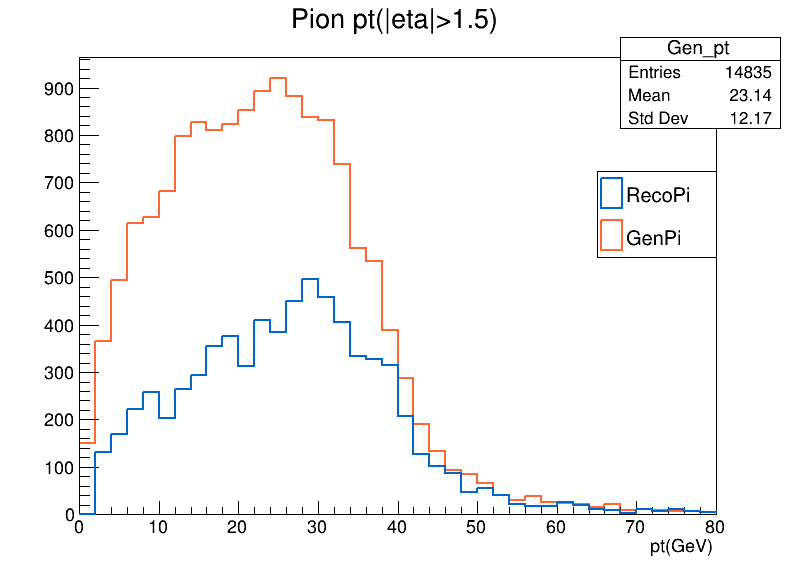

4945


In [4]:
auto file_path = "l1Nano_WTo3Pion_PU200_iso.root";
auto tree_name = "Events";

ROOT::RDataFrame df(tree_name,file_path);
// df.Describe();

auto df_eta1 = df.Filter(eta_filter, {"GenPi_eta"})
                .Define("RecoPuppi_idx", RecoTriplet, {"GenPi_pt", "GenPi_eta", "GenPi_phi", "GenPi_charge", "L1Puppi_pt", "L1Puppi_eta", "L1Puppi_phi", "L1Puppi_charge", "L1Puppi_pdgId"})
                .Define("RecoGen_idx", RecoTripletGen, {"GenPi_pt", "GenPi_eta", "GenPi_phi", "GenPi_charge", "L1Puppi_pt", "L1Puppi_eta", "L1Puppi_phi", "L1Puppi_charge", "L1Puppi_pdgId"})
                .Filter(notempty, {"RecoGen_idx"})
                .Define("Reco_pt", "Take(L1Puppi_pt, RecoPuppi_idx)")
                .Define("Gen_pt", "Take(GenPi_pt, RecoGen_idx)");

std::cout <<*df_eta1.Count()<< std::endl;

auto hist_rec = df_eta1.Histo1D({"Matched_pt", "Matched pion pt(|eta|>1.5);pt(GeV)", 40, 0, 80}, "Reco_pt");
auto hist_gen = df_eta1.Histo1D({"Gen_pt", "Pion pt(|eta|>1.5);pt(GeV)", 40, 0, 80}, "GenPi_pt");
auto c1 = new TCanvas("c1", "c1", 800,600);

hist_rec->SetLineColor(kAzure+2);
hist_rec->SetLineWidth(2);

hist_gen->SetLineColor(kOrange+8);
hist_gen->SetLineWidth(2);

hist_gen -> Draw();
hist_rec -> Draw("same");

auto legend = new TLegend(0.75,0.55,0.9,0.70); // (x1, y1, x2, y2)
legend->AddEntry("Matched_pt", "RecoPi", "f"); 
legend->AddEntry("Gen_pt", "GenPi", "f");
legend-> Draw();

c1 -> Draw();

In [5]:
int nbin = hist_gen -> GetNbinsX();
Vec<double> efficiencies;

for(int i=1; i<nbin; i++){ // ignore i=0 due to Getbincontent output and i=1 due to 0 division 
    double eff = (hist_rec -> GetBinContent(i))/(hist_gen -> GetBinContent(i));
    efficiencies.push_back(eff);

}
std::cout << efficiencies << std::endl;

{ 0, 0.358904, 0.342105, 0.362602, 0.410543, 0.297654, 0.331242, 0.354293, 0.437037, 0.456311, 0.36694, 0.458007, 0.417845, 0.508494, 0.591885, 0.551683, 0.548038, 0.594306, 0.614232, 0.809769, 0.724739, 0.673684, 0.766917, 0.925532, 0.552941, 0.846154, 0.97561, 0.677419, 0.447368, 0.68, 1.08696, 0.909091, 0.733333, 0.409091, 0.333333, 1.09091, 0.777778, 1.375, 1 }


## $|\eta|<1.5$

In [6]:
bool eta_filter2(ROOT::VecOps::RVec<float> v){
    return ROOT::VecOps::All(ROOT::VecOps::Map(v, [](float x){return (abs(x)<1.5); }));
}

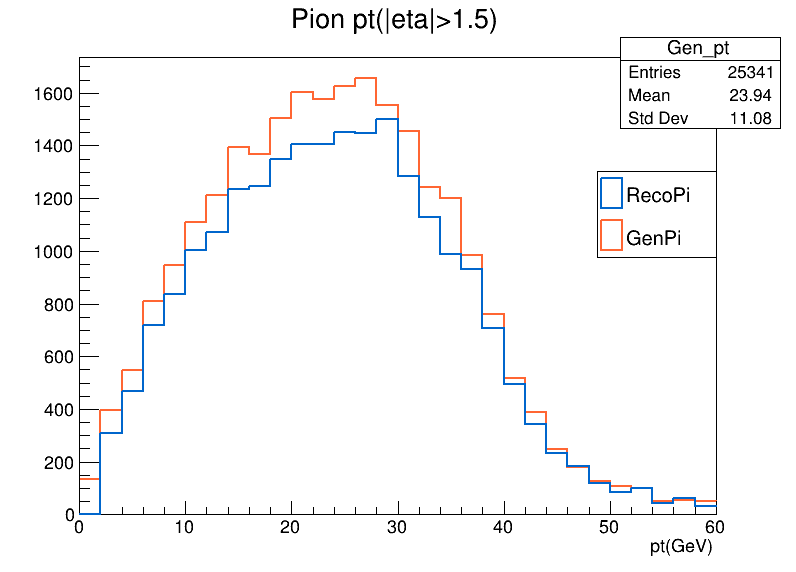

8447


In [7]:
auto df_eta2 = df.Filter(eta_filter2, {"GenPi_eta"})
                .Define("RecoPuppi_idx", RecoTriplet,   {"GenPi_pt", "GenPi_eta", "GenPi_phi", "GenPi_charge", "L1Puppi_pt", "L1Puppi_eta", "L1Puppi_phi", "L1Puppi_charge", "L1Puppi_pdgId"})
                .Define("RecoGen_idx",   RecoTripletGen,{"GenPi_pt", "GenPi_eta", "GenPi_phi", "GenPi_charge", "L1Puppi_pt", "L1Puppi_eta", "L1Puppi_phi", "L1Puppi_charge", "L1Puppi_pdgId"})
                .Filter(notempty, {"RecoGen_idx"})
                .Filter(notempty, {"RecoPuppi_idx"})
                .Define("Reco_pt", "Take(L1Puppi_pt, RecoPuppi_idx)");
                // .Define("Gen_pt", "Take(GenPi_pt, RecoGen_idx)");

std::cout <<*df_eta2.Count()<< std::endl;

auto hist_rec2 = df_eta2.Histo1D({"Matched_pt", "Matched pion pt(|eta|>1.5);pt(GeV)", 30, 0, 60}, "Reco_pt");
auto hist_gen2 = df_eta2.Histo1D({"Gen_pt", "Pion pt(|eta|>1.5);pt(GeV)", 30, 0, 60}, "GenPi_pt");
auto c2 = new TCanvas("c2", "c2", 800,600);

hist_rec2->SetLineColor(kAzure+2);
hist_rec2->SetLineWidth(2);

hist_gen2->SetLineColor(kOrange+8);
hist_gen2->SetLineWidth(2);

hist_gen2 -> Draw();
hist_rec2 -> Draw("same");

auto legend = new TLegend(0.75,0.55,0.9,0.70); // (x1, y1, x2, y2)
legend->AddEntry("Matched_pt", "RecoPi", "f"); 
legend->AddEntry("Gen_pt", "GenPi", "f");
legend-> Draw();

c2 -> Draw();

In [8]:
int nbin = hist_gen2 -> GetNbinsX();
Vec<double> efficiencies2;

for(int i=1; i<nbin; i++){ // ignore i=0 due to Getbincontent output and i=1 due to 0 division 
    double eff = (hist_rec2 -> GetBinContent(i))/(hist_gen2 -> GetBinContent(i));
    efficiencies2.push_back(eff);

}
std::cout << efficiencies2 << std::endl;

{ 0, 0.786802, 0.854015, 0.887654, 0.882788, 0.904332, 0.883567, 0.884588, 0.912884, 0.897538, 0.876559, 0.892698, 0.893473, 0.874244, 0.966538, 0.881181, 0.908944, 0.824167, 0.947101, 0.927727, 0.96124, 0.881137, 0.939516, 1.02235, 0.929688, 0.788991, 1, 0.788462, 1.10714 }


## Eta Filter $|\eta|<1.5$

In [9]:
auto all_eta_filter(Vec<float> eta){
    Vec<int> idx;
    for(int i=0;i<eta.size();i++){
        if(abs(eta[i])<1.5) idx.push_back(i);
    }
    return idx;
}

In [10]:
auto df1_eta = df.Define("eta_idx", all_eta_filter, {"GenPi_eta"})
                .Define("gen_pt",  "Take(GenPi_pt, eta_idx)")
                .Define("gen_eta", "Take(GenPi_eta, eta_idx)")
                .Define("gen_phi", "Take(GenPi_phi, eta_idx)")
                .Define("gen_charge", "Take(GenPi_charge, eta_idx)")
                .Define("RecoPuppi_idx", RecoTriplet,  {"gen_pt", "gen_eta", "gen_phi", "gen_charge", "L1Puppi_pt", "L1Puppi_eta", "L1Puppi_phi", "L1Puppi_charge", "L1Puppi_pdgId"})
                .Define("RecoGen_idx", RecoTripletGen, {"gen_pt", "gen_eta", "gen_phi", "gen_charge", "L1Puppi_pt", "L1Puppi_eta", "L1Puppi_phi", "L1Puppi_charge", "L1Puppi_pdgId"})
                .Filter(notempty, {"RecoGen_idx"})
                .Define("Reco_pt", "Take(L1Puppi_pt, RecoPuppi_idx)")
                .Define("Gen_pt", "Take(GenPi_pt, RecoGen_idx)");

In [11]:
auto ee = df1_eta.Take<ROOT::VecOps::RVec<unsigned long>>("RecoPuppi_idx").GetValue()[1];
ee

(ROOT::VecOps::RVec<unsigned long> &) { 1 }


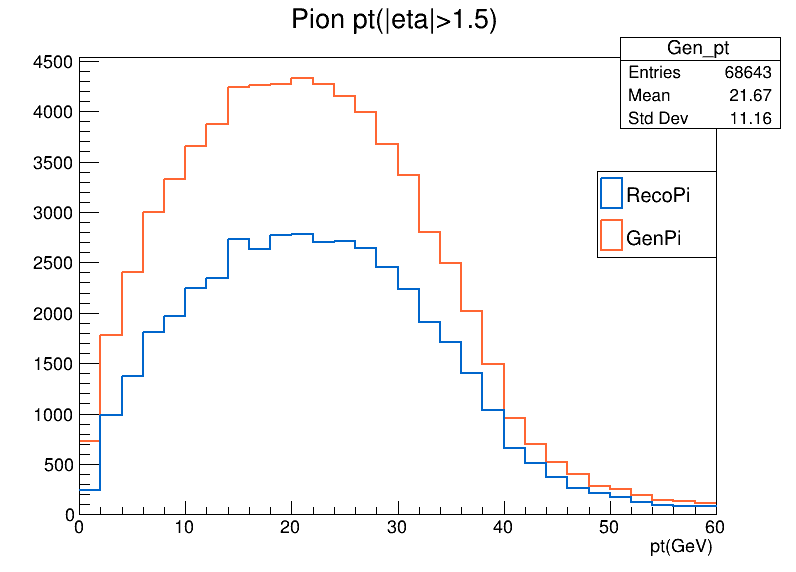

22881


In [12]:
std::cout <<*df1_eta.Count()<< std::endl;

auto hist_rec3 = df1_eta.Histo1D({"Matched_pt", "Matched pion pt(|eta|>1.5);pt(GeV)", 30, 0, 60}, "Gen_pt");
auto hist_gen3 = df1_eta.Histo1D({"Gen_pt", "Pion pt(|eta|>1.5);pt(GeV)", 30, 0, 60}, "GenPi_pt");
auto c3 = new TCanvas("c3", "c3", 800,600);

hist_rec3->SetLineColor(kAzure+2);
hist_rec3->SetLineWidth(2);

hist_gen3->SetLineColor(kOrange+8);
hist_gen3->SetLineWidth(2);

hist_gen3 -> Draw();
hist_rec3 -> Draw("same");

auto legend = new TLegend(0.75,0.55,0.9,0.70); // (x1, y1, x2, y2)
legend->AddEntry("Matched_pt", "RecoPi", "f"); 
legend->AddEntry("Gen_pt", "GenPi", "f");
legend-> Draw();

c3 -> Draw();

In [13]:
int nbin = hist_gen3 -> GetNbinsX();
Vec<double> efficiencies3;

for(int i=1; i<nbin; i++){ // ignore i=0 due to Getbincontent output and i=1 due to 0 division 
    double eff = (hist_rec3 -> GetBinContent(i))/(hist_gen3 -> GetBinContent(i));
    efficiencies3.push_back(eff);

}
std::cout << efficiencies3 << std::endl;

{ 0.326446, 0.556492, 0.569531, 0.603598, 0.590021, 0.614501, 0.604964, 0.645047, 0.617191, 0.650269, 0.643386, 0.633724, 0.652761, 0.660907, 0.66712, 0.664489, 0.6794, 0.684866, 0.694362, 0.697315, 0.69255, 0.732857, 0.712909, 0.665829, 0.740214, 0.681102, 0.647668, 0.657343, 0.661538 }


In [14]:
TEfficiency* eff1 = new TEfficiency("effic",hist_rec3.GetValue(),hist_gen3.GetValue());
auto c4 = new TCanvas("c4", "c4", 800,600);
eff1 -> SetLineColor(kBlue);
eff1 -> SetLineWidth(2);
eff1->SetStatisticOption(TEfficiency::kBUniform);

eff1->Draw("AP");
c4 ->Draw();

input_line_121:2:26: error: no matching constructor for initialization of 'TEfficiency'
 TEfficiency* eff1 = new TEfficiency("effic",hist_rec3.GetValue(),hist_gen3.GetValue());
                         ^           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/home/pietro/anaconda3/envs/root-env/include/TEfficiency.h:75:7: note: candidate constructor not viable: requires 2 arguments, but 3 were provided
      TEfficiency(const TH1& passed,const TH1& total);
      ^
/home/pietro/anaconda3/envs/root-env/include/TEfficiency.h:76:7: note: candidate constructor not viable: requires 4 arguments, but 3 were provided
      TEfficiency(const char* name,const char* title,Int_t nbins,
      ^
/home/pietro/anaconda3/envs/root-env/include/TEfficiency.h:91:7: note: candidate constructor not viable: requires single argument 'heff', but 3 arguments were provided
      TEfficiency(const TEfficiency& heff);
      ^
/home/pietro/anaconda3/envs/root-env/include/TEfficiency.h:78:7: note: candidate cons

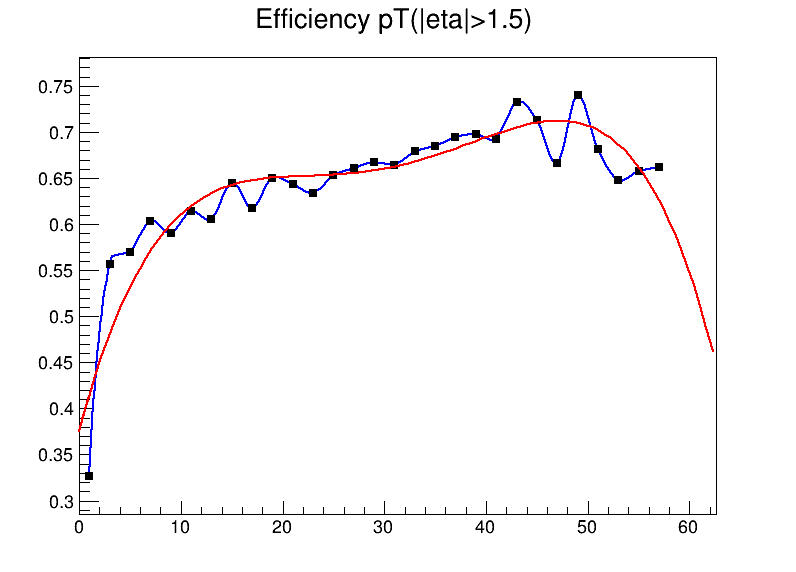


****************************************
Minimizer is Linear / Migrad
Chi2                      =    0.0261057
NDf                       =           24
p0                        =     0.375777   +/-   0.0311234   
p1                        =    0.0410953   +/-   0.00745167  
p2                        =  -0.00225002   +/-   0.000522233 
p3                        =  5.28611e-05   +/-   1.35265e-05 
p4                        = -4.33046e-07   +/-   1.1571e-07  


In [23]:
Vec<double> binCenters;
for (int i = 1; i<hist_rec3->GetNbinsX(); i++) {
    binCenters.push_back(hist_rec3->GetBinCenter(i));
}

// std::cout << binCenters.size() << binCenters << std::endl;
// std::cout << efficiencies4.size() << efficiencies4 << std::endl;

auto c6 = new TCanvas("c6", "c6", 800,600);
auto g  = new TGraph();
g->SetTitle("Efficiency pT(|eta|>1.5)");

for(int i=0; i<binCenters.size();i++){
    g->SetPoint(i,binCenters[i], efficiencies3[i]);
}

TF1 *polynomialFit = new TF1("polynomialFit", "pol4");
g->Fit(polynomialFit);

g->SetLineColor(4);
g->SetLineWidth(-2002);
g->SetMarkerStyle(21);
g->Draw("ACP");
polynomialFit->Draw("same");
c6->Draw();

## Eta Filter $|\eta|>1.5$

In [16]:
auto all_eta_filter2(Vec<float> eta){
    Vec<int> idx;
    for(int i=0;i<eta.size();i++){
        if(abs(eta[i])>1.5) idx.push_back(i);
    }
    return idx;
}

In [17]:
auto df2_eta = df.Define("eta_idx", all_eta_filter2, {"GenPi_eta"})
                .Define("gen_pt",  "Take(GenPi_pt, eta_idx)")
                .Define("gen_eta", "Take(GenPi_eta, eta_idx)")
                .Define("gen_phi", "Take(GenPi_phi, eta_idx)")
                .Define("gen_charge", "Take(GenPi_charge, eta_idx)")
                .Define("RecoPuppi_idx", RecoTriplet,  {"gen_pt", "gen_eta", "gen_phi", "gen_charge", "L1Puppi_pt", "L1Puppi_eta", "L1Puppi_phi", "L1Puppi_charge", "L1Puppi_pdgId"})
                .Define("RecoGen_idx", RecoTripletGen, {"gen_pt", "gen_eta", "gen_phi", "gen_charge", "L1Puppi_pt", "L1Puppi_eta", "L1Puppi_phi", "L1Puppi_charge", "L1Puppi_pdgId"})
                .Filter(notempty, {"RecoGen_idx"})
                .Define("Reco_pt", "Take(L1Puppi_pt, RecoPuppi_idx)")
                .Define("Gen_pt", "Take(GenPi_pt, RecoGen_idx)");

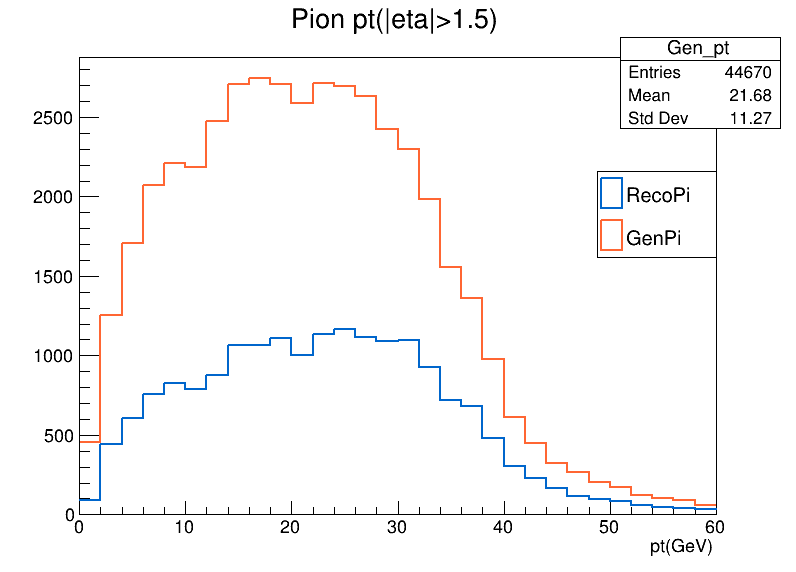

14890


In [18]:
std::cout <<*df2_eta.Count()<< std::endl;

auto hist_rec4 = df2_eta.Histo1D({"Matched_pt", "Matched pion pt(|eta|>1.5);pt(GeV)", 30, 0, 60}, "Gen_pt").GetValue();
auto hist_gen4 = df2_eta.Histo1D({"Gen_pt", "Pion pt(|eta|>1.5);pt(GeV)", 30, 0, 60}, "GenPi_pt").GetValue();
auto c4 = new TCanvas("c4", "c4", 800,600);

hist_rec4.SetLineColor(kAzure+2);
hist_rec4.SetLineWidth(2);

hist_gen4.SetLineColor(kOrange+8);
hist_gen4.SetLineWidth(2);

hist_gen4 . Draw();
hist_rec4 . Draw("same");

auto legend = new TLegend(0.75,0.55,0.9,0.70); // (x1, y1, x2, y2)
legend->AddEntry("Matched_pt", "RecoPi", "f"); 
legend->AddEntry("Gen_pt", "GenPi", "f");
legend-> Draw();

c4 -> Draw();

### Efficiency

In [19]:
int nbin = hist_gen4.GetNbinsX();
Vec<double> efficiencies4;

for(int i=1; i<nbin; i++){ // ignore i=0 due to Getbincontent output and i=1 due to 0 division 
    double eff = (hist_rec4.GetBinContent(i))/(hist_gen4.GetBinContent(i));
    efficiencies4.push_back(eff);

}
std::cout << efficiencies4 << std::endl;

{ 0.199125, 0.352753, 0.354971, 0.364337, 0.373701, 0.361595, 0.353393, 0.394163, 0.388038, 0.40946, 0.388094, 0.418296, 0.432974, 0.423033, 0.449897, 0.477372, 0.467742, 0.460847, 0.500368, 0.48873, 0.5, 0.508929, 0.520124, 0.443609, 0.480392, 0.488235, 0.467213, 0.447619, 0.466667 }


In [20]:
TEfficiency::CheckConsistency(hist_rec4,hist_gen4)

(bool) true


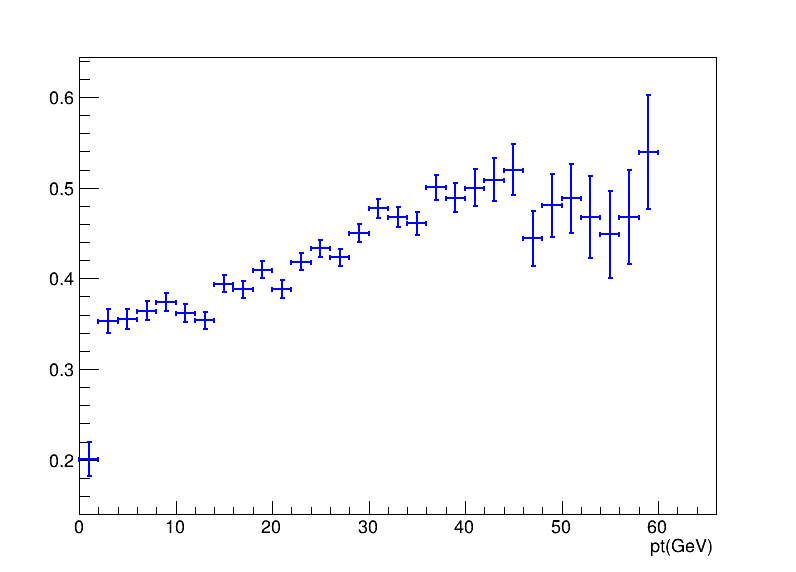

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4


In [21]:
TEfficiency* eff = new TEfficiency(hist_rec4,hist_gen4);
auto c4 = new TCanvas("c4", "c4", 800,600);
eff -> SetLineColor(kBlue);
eff -> SetLineWidth(2);
eff->SetStatisticOption(TEfficiency::kBUniform);

eff->Draw("AP");
c4 ->Draw();

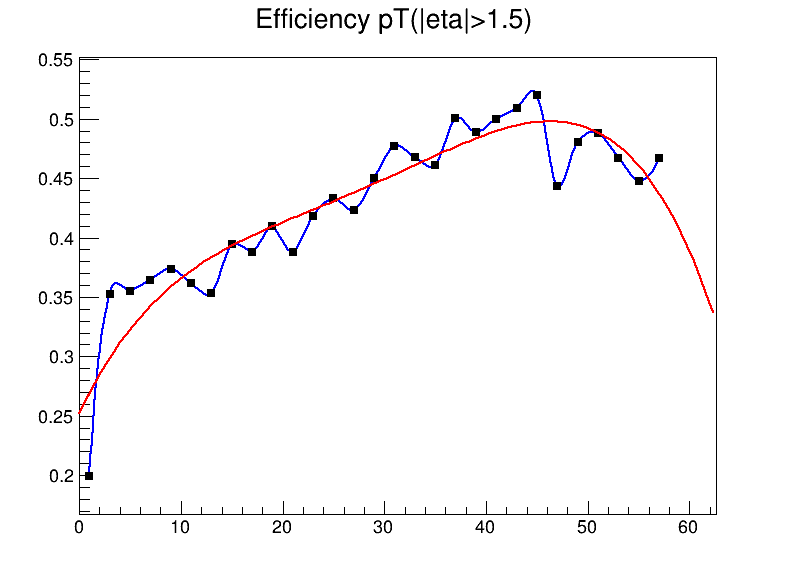


****************************************
Minimizer is Linear / Migrad
Chi2                      =    0.0182712
NDf                       =           24
p0                        =     0.252085   +/-   0.0260377   
p1                        =    0.0176736   +/-   0.00623403  
p2                        = -0.000817681   +/-   0.000436898 
p3                        =  2.04797e-05   +/-   1.13162e-05 
p4                        = -1.85492e-07   +/-   9.68026e-08 


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4


In [22]:
Vec<double> binCenters;
for (int i = 1; i<hist_rec4.GetNbinsX(); i++) {
    binCenters.push_back(hist_rec4.GetBinCenter(i));
}

// std::cout << binCenters.size() << binCenters << std::endl;
// std::cout << efficiencies4.size() << efficiencies4 << std::endl;

auto c4 = new TCanvas("c4", "c4", 800,600);
auto g  = new TGraph();
g->SetTitle("Efficiency pT(|eta|>1.5)");

for(int i=0; i<binCenters.size();i++){
    g->SetPoint(i,binCenters[i], efficiencies4[i]);
}

TF1 *polynomialFit = new TF1("polynomialFit", "pol4");
g->Fit(polynomialFit);

g->SetLineColor(4);
g->SetLineWidth(-2002);
g->SetMarkerStyle(21);
g->Draw("ACP");
polynomialFit->Draw("same");
c4->Draw();